In [1]:
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from astropy.cosmology import Planck15 as cosmo
import astropy.constants as const

import sys
if 'SuperBoL' not in sys.path:
    sys.path.append('SuperBoL')
import superbol
from superbol.fit_blackbody import bb_fit_parameters, bb_flux_nounits
from superbol.fbol import (ir_correction, uv_correction_blackbody,
                           uv_correction_linear)

In [2]:
# load the GROND lightcurve
grond_lc = table.Table.read('../data/grond_lc/v4.fits')



# perform extinction correction
EXTINCTION_COEFF = {
    'g': 3.303,
    'r': 2.285,
    'i': 1.698,
    'z': 1.263,
    'J': 0.723,
    'H': 0.460,
    'K': 0.310
}
ebv = 0.165

for band in 'grizJHK':
    grond_lc['mag_%s' % band] -= EXTINCTION_COEFF[band] * ebv
idx = grond_lc['magerr_g'] < 0.1
grond_lc = grond_lc[idx]
grond_lc

<Table length=5>
       mjd              mag_g        ...       mag_K              magerr_K     
     float64           float64       ...      float64             float64      
----------------- ------------------ ... ------------------ -------------------
58778.11519076466   18.2764205045909 ...  18.16547601201091 0.13358076498051322
58783.09287482079 18.466301671202977 ... 18.201162475552827  0.1373648790066015
58789.05341837661  18.41023353103948 ... 18.013348144257634  0.2292517711743819
58794.05187395877  18.47761113698111 ...  18.07488507095373  0.2034494191010531
58814.05056632643  18.72959814445816 ... 18.846221558109207  0.1810791601087106

In [3]:
plt.figure(figsize=(10,8))
plt.errorbar(grond_lc['mjd'], grond_lc['mag_g'], yerr=grond_lc['magerr_g'])
plt.errorbar(grond_lc['mjd'], grond_lc['mag_r'], yerr=grond_lc['magerr_r'])
plt.errorbar(grond_lc['mjd'], grond_lc['mag_i'], yerr=grond_lc['magerr_i'])
plt.errorbar(grond_lc['mjd'], grond_lc['mag_z'], yerr=grond_lc['magerr_z'])
grond_lc
# all mags are in AB mags

<Table length=5>
       mjd              mag_g        ...       mag_K              magerr_K     
     float64           float64       ...      float64             float64      
----------------- ------------------ ... ------------------ -------------------
58778.11519076466   18.2764205045909 ...  18.16547601201091 0.13358076498051322
58783.09287482079 18.466301671202977 ... 18.201162475552827  0.1373648790066015
58789.05341837661  18.41023353103948 ... 18.013348144257634  0.2292517711743819
58794.05187395877  18.47761113698111 ...  18.07488507095373  0.2034494191010531
58814.05056632643  18.72959814445816 ... 18.846221558109207  0.1810791601087106

In [4]:
# load distance and convert to distance in cm
redshift = table.Table.read('../const/distance/current', format='ascii')
redshift.pprint()

dist = cosmo.luminosity_distance(redshift['redshift'][0]).to(u.cm)
dist_cm = dist.value
dist_pc = dist.to(u.pc).value
dist_mod = 5*np.log10(dist_pc) - 5
dist

redshift err_redshift
-------- ------------
0.014353      1.3e-05


<Quantity 1.98155725e+26 cm>

array([9.94876851e+41, 9.01408221e+41, 8.30838928e+41, 7.81787227e+41,
       5.36944051e+41])

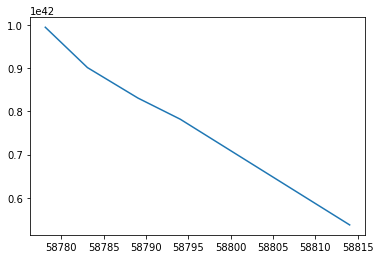

In [5]:
# (band, wavelength, AB zeropoint flux)
# taken from http://svo2.cab.inta-csic.es/svo/theory//fps3/index.php?id=LaSilla/GROND.J&&mode=browse&gname=LaSilla&gname2=GROND#filter
GROND_INS = [
    ('g', 4586.85, 5.36482e-9),
    ('r', 6220.09, 2.92735e-9),
    ('i', 7640.69, 1.88225e-9),
    ('z', 8989.58, 1.36524e-9),
    ('J', 12399.17, 7.25809e-10),
    ('H', 16468.80, 4.08192e-10),
    ('K', 21705.48, 2.34388e-10)
]
bands = [x[0] for x in GROND_INS]
cent_wavelengths = [x[1] for x in GROND_INS]
zero_fluxes = [x[2] for x in GROND_INS]

# extract data from LC
mjd = grond_lc['mjd']
fluxes = []
for i in range(len(grond_lc)):
    a = []
    e = []
    for band in bands:
        # TODO: convert them..
        a.append(grond_lc['mag_%s' % band][i])
        e.append(grond_lc['magerr_%s' % band][i])
    # convert to fluxes
    fluxes.append(zero_fluxes*10**(-0.4*np.array(a)))

# now integrate each point
fluxes_qbol = np.empty(len(grond_lc))
for i in range(len(grond_lc)):
    f_qbol = np.trapz(fluxes[i], cent_wavelengths)
    fluxes_qbol[i] = f_qbol


# convert to luminosity
lums_qbol = 4*np.pi*dist_cm**2*fluxes_qbol

plt.plot(mjd, lums_qbol)

lums_qbol

array([9.76628706e+41, 8.83858567e+41, 8.17965935e+41, 7.67739685e+41,
       5.27768874e+41])

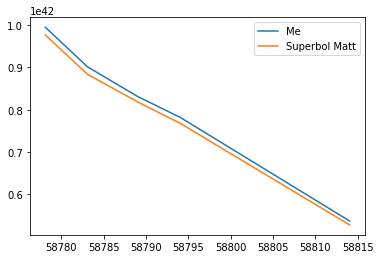

In [6]:
# (band, wavelength, AB or Vega zeropoint flux)
# values taken from Matt Nicholls superbol

#All values in 1e-11 erg/s/cm2/Angs
zp = {'u': 859.5, 'g': 466.9, 'r': 278.0, 'i': 185.2, 'z': 137.8, 'y': 118.2, 'Y': 118.2,
      'U': 417.5, 'B': 632.0, 'V': 363.1, 'R': 217.7, 'G': 240.0, 'I': 112.6, 'J': 31.47, 'H': 11.38,
      'K': 3.961, 'S': 536.2, 'D': 463.7, 'A': 412.3, 'F': 4801., 'N': 2119., 'o': 236.2, 'c': 383.3}
#Effective wavelengths (in Angs)
wle = {'u': 3560,  'g': 4830, 'r': 6260, 'i': 7670, 'z': 8890, 'y': 9600, 'Y': 9600,
       'U': 3600,  'B': 4380, 'V': 5450, 'R': 6410, 'G': 6730, 'I': 7980, 'J': 12200, 'H': 16300,
       'K': 21900, 'S': 2030, 'D': 2231, 'A': 2634, 'F': 1516, 'N': 2267, 'o': 6790, 'c': 5330}

#Filter widths (in Angs)
width = {'u': 458,  'g': 928, 'r': 812, 'i': 894,  'z': 1183, 'y': 628, 'Y': 628,
         'U': 485,  'B': 831, 'V': 827, 'R': 1389, 'G': 4203, 'I': 899, 'J': 1759, 'H': 2041,
         'K': 2800, 'S': 671, 'D': 446, 'A': 821,  'F': 268,  'N': 732, 'o': 2580, 'c': 2280}

# from Matt Nicholls superbol:
#Extinction coefficients in A_lam / E(B-V). Uses York Extinction Solver (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/YorkExtinctionSolver/coefficients.cgi)
extco = {'u': 4.786,  'g': 3.587, 'r': 2.471, 'i': 1.798,  'z': 1.403, 'y': 1.228, 'Y': 1.228,
         'U': 4.744,  'B': 4.016, 'V': 3.011, 'R': 2.386, 'G': 2.216, 'I': 1.684, 'J': 0.813, 'H': 0.516,
         'K': 0.337, 'S': 8.795, 'D': 9.270, 'A': 6.432,  'F': 8.054,  'N': 8.969, 'o': 2.185, 'c': 3.111}

GROND_INS = []
for band in 'grizJHK':
    GROND_INS.append((band, wle[band], zp[band]*1e-11, width[band]))
bands = [x[0] for x in GROND_INS]
cent_wavelengths = [x[1] for x in GROND_INS]
zero_fluxes = [x[2] for x in GROND_INS]
widths = [x[3] for x in GROND_INS]

#df['mag_J'] -= 0.91
#df['mag_H'] -= 1.39
#df['mag_K'] -= 1.85

AB_TO_VEGA = {
    'J': -0.91,
    'H': -1.39,
    'K': -1.85,
    'g': 0,
    'r': 0,
    'i': 0,
    'z': 0
}

# extract data from LC
mjd = grond_lc['mjd']
fluxes = []
for i in range(len(grond_lc)):
    a = []
    e = []
    for band in bands:
        # TODO: convert them..
        a.append(grond_lc['mag_%s' % band][i] + AB_TO_VEGA[band] + EXTINCTION_COEFF[band]*ebv - extco[band]*ebv)
        e.append(grond_lc['magerr_%s' % band][i])
    # convert to fluxes
    fluxes.append(zero_fluxes*10**(-0.4*np.array(a)))

wlref1 = [wle['g']-width['g']/2]
wlref1.extend(cent_wavelengths)
wlref1.append(wle['K']+width['K']/2)
    
# now integrate each point
fluxes_qbol = np.empty(len(grond_lc))
for i in range(len(grond_lc)):
    fluxes2 = [0]
    fluxes2.extend(fluxes[i])
    fluxes2.append(0)
    f_qbol = np.trapz(np.array(fluxes2), np.array(wlref1))
    fluxes_qbol[i] = f_qbol


# convert to luminosity
lums_qbol2 = 4*np.pi*dist_cm**2*fluxes_qbol

plt.plot(mjd, lums_qbol, label='Me')
plt.plot(mjd, lums_qbol2, label='Superbol Matt')
plt.legend()
lums_qbol2

In [7]:
# (band, wavelength, AB or Vega zeropoint flux)
# values taken from the better superbol


GROND_INS = []
for band in 'grizJHK':
    GROND_INS.append((band, wle[band], zp[band]*1e-11))
bands = [x[0] for x in GROND_INS]
cent_wavelengths = [x[1] for x in GROND_INS]
zero_fluxes = [x[2] for x in GROND_INS]

# extract data from LC
mjd = grond_lc['mjd']
fluxes = []
for i in range(len(grond_lc)):
    a = []
    e = []
    for band in bands:
        # TODO: convert them..
        a.append(grond_lc['mag_%s' % band][i])
        e.append(grond_lc['magerr_%s' % band][i])
    # convert to fluxes
    fluxes.append(zero_fluxes*10**(-0.4*np.array(a)))

# now integrate each point
fluxes_qbol = np.empty(len(grond_lc))
for i in range(len(grond_lc)):
    f_qbol = np.trapz(fluxes[i], cent_wavelengths)
    fluxes_qbol[i] = f_qbol


# convert to luminosity
lums_qbol2 = 4*np.pi*dist_cm**2*fluxes_qbol

plt.plot(mjd, lums_qbol)
plt.plot(mjd, lums_qbol2)

lums_qbol2

array([7.65550772e+41, 7.00517351e+41, 6.38936370e+41, 6.12972846e+41,
       4.25029760e+41])

In [8]:
# lyman parameters from paper

lyman_pbc_params = np.array([
    0.168, -0.407, -0.608, # c0 c1 c2
    0.074 # rms
])

lyman_bc_params = np.array([
    0.054, -0.195, -0.719, # c0 c1 c2
    0.076 # rms
])

lyman_pbc_params_gi = np.array([
    0.051, -0.511, -0.195, # c0 c1 c2
    0.055 # rms
])

lyman_bc_params_gi = np.array([
    -0.029, -0.404, -0.230, # c0 c1 c2
    0.060 # rms
])

lyman_bc_cooling_params = np.array([
    -0.146, 0.479, 2.257, # c0 c1 c2
    0.078 # rms
])

COLOR_RANGES = {
    'pbc': (-0.3, 1.0),
    'bc': (-0.3, 1.0),
    'pbc_gi': (-0.8, 1.1),
    'bc_gi': (-0.8, 1.1),
    'cooling': (-0.3, 0.3)
}


# TODO: add support for other band configurations than just (g,r)
# TODO: add error estimation

def compute_bol_mag(mag_g, mag_r, method='pbc'):
    if method == 'pbc':
        c0, c1, c2, rms = lyman_pbc_params
    elif method == 'bc':
        c0, c1, c2, rms = lyman_bc_params
    elif method == 'pbc_gi':
        c0, c1, c2, rms = lyman_pbc_params_gi
    elif method == 'bc_gi':
        c0, c1, c2, rms = lyman_bc_params_gi
    elif method == 'cooling':
        c0, c1, c2, rms = lyman_bc_cooling_params
    else:
        raise ValueError('Unknown method: %s' % method)

    dmag = mag_g - mag_r

    # validate color range
    color_min = dmag.min()
    color_max = dmag.max()

    if color_min < COLOR_RANGES[method][0]:
        print('* WARN: color in lc exceeds lyman (min lc = %f < %f)' % (color_min, COLOR_RANGES[method][0]))
    if color_max > COLOR_RANGES[method][1]:
        print('* WARN: color in lc exceeds lyman (max lc = %f > %f)' % (color_max, COLOR_RANGES[method][1]))
    
    bol_correction = c0 + c1*dmag + c2*dmag ** 2
    
    return mag_g + bol_correction

def convert_luminosity(abs_mag):
    luminosity = (const.L_sun.cgs.value)*10 ** ((4.74 - abs_mag)/2.5)
    return luminosity


No handles with labels found to put in legend.


* WARN: color in lc exceeds lyman (max lc = 1.127282 > 1.100000)
* WARN: color in lc exceeds lyman (max lc = 1.127282 > 1.100000)
* WARN: color in lc exceeds lyman (max lc = 1.127282 > 0.300000)


Text(0.5, 0, 'MJD [d]')

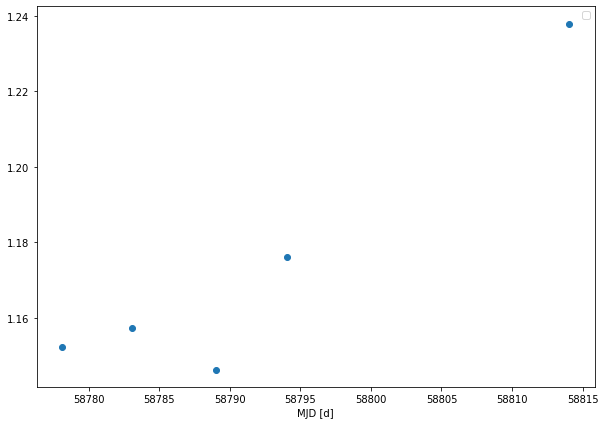

In [9]:
# now compute lyman qbol
g_mags = np.array(grond_lc['mag_g'], copy=True)
i_mags = np.array(grond_lc['mag_i'], copy=True)

lyman_mag = compute_bol_mag(g_mags, i_mags, 'pbc_gi')
abs_mag = lyman_mag - dist_mod
lums_lyman_pbc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, i_mags, 'bc_gi')
abs_mag = lyman_mag - dist_mod
lums_lyman_bc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, i_mags, 'cooling')
abs_mag = lyman_mag - dist_mod
lums_lyman_cooling = convert_luminosity(abs_mag)

plt.figure(figsize=(10,7))
#plt.plot(mjd, lums_qbol, label='GROND qbol')
#plt.plot(mjd, lums_lyman_pbc, label='Lyman pBC (gi)')
#plt.plot(mjd, lums_lyman_bc, label='Lyman BC (gi)')
#plt.plot(mjd, lums_lyman_cooling, label='Lyman Cooling')

idx = grond_lc['magerr_g'] < 0.15
plt.plot(mjd[idx], (lums_lyman_bc/lums_qbol)[idx], 'o')

plt.legend()
#plt.yscale('log')
plt.xlabel('MJD [d]')
#plt.ylabel('L_qbol [erg/s]')

No handles with labels found to put in legend.


* WARN: color in lc exceeds lyman (max lc = 0.902937 > 0.300000)


Text(0.5, 0, 'MJD [d]')

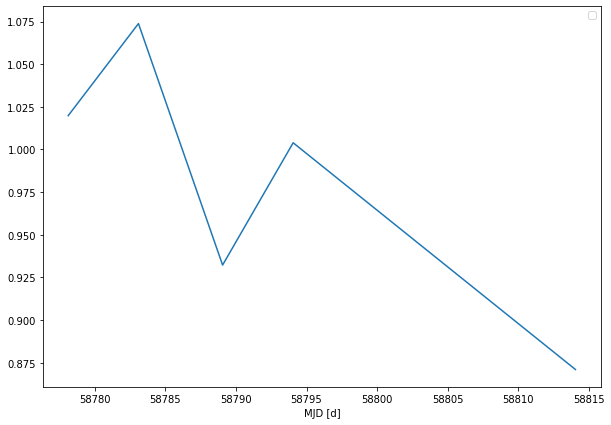

In [10]:
# now compute lyman qbol
g_mags = np.array(grond_lc['mag_g'], copy=True)
r_mags = np.array(grond_lc['mag_r'], copy=True)

lyman_mag = compute_bol_mag(g_mags, r_mags, 'pbc')
abs_mag = lyman_mag - dist_mod
lums_lyman_pbc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, r_mags, 'bc')
abs_mag = lyman_mag - dist_mod
lums_lyman_bc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, r_mags, 'cooling')
abs_mag = lyman_mag - dist_mod
lums_lyman_cooling = convert_luminosity(abs_mag)

plt.figure(figsize=(10,7))
#plt.plot(mjd, lums_qbol, label='GROND qbol')
#plt.plot(mjd, lums_lyman_pbc, label='Lyman pBC (gi)')
#plt.plot(mjd, lums_lyman_bc, label='Lyman BC (gi)')
#plt.plot(mjd, lums_lyman_cooling, label='Lyman Cooling')
idx = grond_lc['magerr_g'] < 0.15
plt.plot(mjd[idx], (lums_lyman_pbc/lums_qbol)[idx])
plt.legend()
#plt.yscale('log')
plt.xlabel('MJD [d]')
#plt.ylabel('L_qbol [erg/s]')

* WARN: color in lc exceeds lyman (max lc = 0.902937 > 0.300000)


Text(0, 0.5, 'L_qbol [erg/s]')

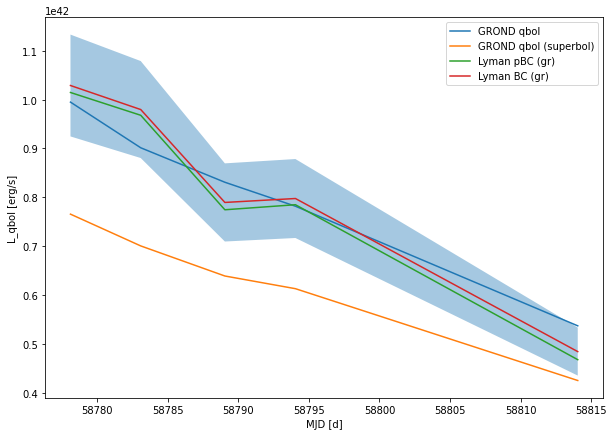

In [11]:
# now compute lyman qbol
g_mags = np.array(grond_lc['mag_g'], copy=True)
r_mags = np.array(grond_lc['mag_r'], copy=True)

lyman_mag = compute_bol_mag(g_mags, r_mags, 'pbc')
abs_mag = lyman_mag - dist_mod
lums_lyman_pbc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, r_mags, 'bc')
abs_mag = lyman_mag - dist_mod
lums_lyman_bc = convert_luminosity(abs_mag)
lyman_mag = compute_bol_mag(g_mags, r_mags, 'cooling')
abs_mag = lyman_mag - dist_mod
lums_lyman_cooling = convert_luminosity(abs_mag)

lums_lyman_bc_err = np.abs(lums_lyman_bc * -0.4 * np.log(10) * 0.11)

plt.figure(figsize=(10,7))
plt.plot(mjd, lums_qbol, label='GROND qbol')
plt.plot(mjd, lums_qbol2, label='GROND qbol (superbol)')
plt.plot(mjd, lums_lyman_pbc, label='Lyman pBC (gr)')
plt.plot(mjd, lums_lyman_bc, label='Lyman BC (gr)')
plt.fill_between(mjd, lums_lyman_bc-lums_lyman_bc_err, lums_lyman_bc+lums_lyman_bc_err, alpha=0.4)
#plt.plot(mjd, lums_lyman_cooling, label='Lyman Cooling')
plt.legend()
#plt.yscale('log')
plt.xlabel('MJD [d]')
plt.ylabel('L_qbol [erg/s]')

Text(0.5, 0, 'MJD [d]')

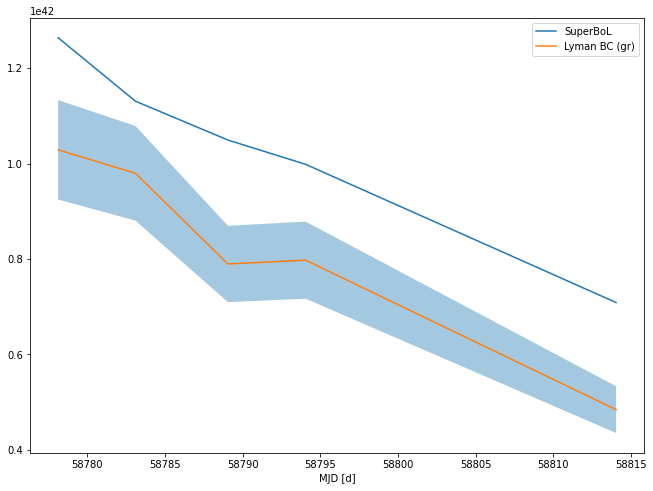

In [12]:
GROND_INS = [
    ('g', 4586.85, 5.36482e-9),
    ('r', 6220.09, 2.92735e-9),
    ('i', 7640.69, 1.88225e-9),
    ('z', 8989.58, 1.36524e-9),
    ('J', 12399.17, 7.25809e-10),
    ('H', 16468.80, 4.08192e-10),
    ('K', 21705.48, 2.34388e-10)
]

INS=GROND_INS
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
#fwhm = [x[2] for x in INS]
zero_flux = [x[2] for x in INS]

plt.figure(figsize=(11,8))
lum_int = np.empty(len(grond_lc))
lum_superbol = np.empty(len(grond_lc))
temps = np.empty(len(grond_lc))
radii = np.empty(len(grond_lc))
for i,row in enumerate(grond_lc):
    mags = list(map(lambda band: row['mag_%s' % band], int_bands))
    #mag_errs = list(map(lambda band: row['e%s' % band]-EXTINCTION_COEFF[band]*ebv, int_bands))
    fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
    flux_errs = np.abs(fluxes * -0.4 * np.log(10) * 0.02)
    
    # simple direction integration
    f_qbol = np.trapz(fluxes, cent_wave)
    lums_qbol = 4*np.pi*dist_cm**2*f_qbol
    lum_int[i] = lums_qbol
    
    # now do the superbol thing
    temperature, angular_radius, perr = bb_fit_parameters(cent_wave, fluxes, flux_errs)
    temps[i] = temperature
    radii[i] = angular_radius
    temperature_err = perr[0]
    angular_radius_err = perr[1]
    longest_wl = np.amax(cent_wave)
    shortest_wl = np.amin(cent_wave)
    shortest_flux = np.amin(fluxes)
    shortest_flux_err = np.amin(flux_errs)
    ir_corr, ir_corr_err = ir_correction(temperature, temperature_err, angular_radius, angular_radius_err, longest_wl)
    uv_corr, uv_corr_err = uv_correction_blackbody(
                    temperature, temperature_err, angular_radius,
                    angular_radius_err, shortest_wl)
    lum_superbol[i] = 4*np.pi*dist_cm**2*(f_qbol + ir_corr + uv_corr)
    
#plt.plot(lc['time'], lum_int/lum_lyman, label='x = UBVRIJHK Integration')
idx = grond_lc['magerr_g'] < 0.1
plt.plot(grond_lc['mjd'][idx], lum_superbol[idx], label='SuperBoL')
plt.plot(mjd, lums_lyman_bc, label='Lyman BC (gr)')
plt.fill_between(mjd, lums_lyman_bc-lums_lyman_bc_err, lums_lyman_bc+lums_lyman_bc_err, alpha=0.4)
plt.legend()
plt.xlabel('MJD [d]')
#plt.ylabel('Ratio x/Lyman')

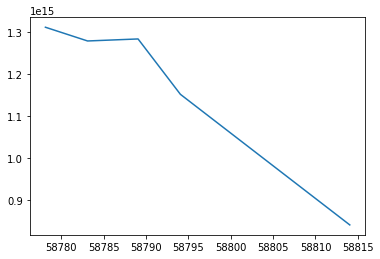

In [15]:
from astropy.cosmology import Planck15 as cosmo
dist = cosmo.luminosity_distance(0.014353).to(u.cm)
plt.plot(grond_lc['mjd'], radii*dist)

Std: 0.002777
Other method: 0.101314


(array([  9.,  56., 131., 233., 252., 165., 111.,  28.,  13.,   2.]),
 array([3.12619868e+40, 3.36528423e+40, 3.60436977e+40, 3.84345532e+40,
        4.08254087e+40, 4.32162641e+40, 4.56071196e+40, 4.79979751e+40,
        5.03888306e+40, 5.27796860e+40, 5.51705415e+40]),
 <BarContainer object of 10 artists>)

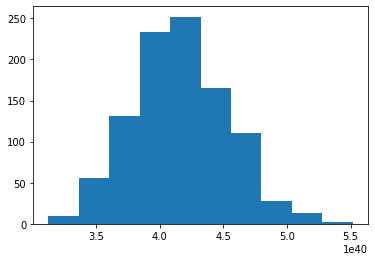

In [193]:
tst_mags = np.random.normal(abs_mag[0], 0.1, size=1000)
tst_lums = convert_luminosity(tst_mags)
print('Std: %f' % (np.std(tst_lums)/lums_lyman_bc[0]))
print('Other method: %f' % (lums_lyman_bc_err[0]/lums_lyman_bc[0]))
plt.hist(tst_lums)

Text(0, 0.5, 'Luminosity')

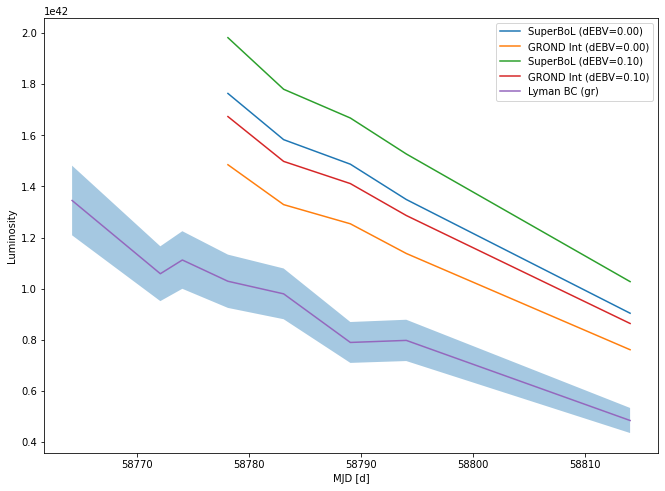

In [202]:
GROND_INS = [
    ('g', 4586.85, 5.36482e-9),
    ('r', 6220.09, 2.92735e-9),
    ('i', 7640.69, 1.88225e-9),
    ('z', 8989.58, 1.36524e-9),
    ('J', 12399.17, 7.25809e-10),
    ('H', 16468.80, 4.08192e-10),
    ('K', 21705.48, 2.34388e-10)
]

INS=GROND_INS
int_bands = [x[0] for x in INS]
cent_wave = [x[1] for x in INS]
#fwhm = [x[2] for x in INS]
zero_flux = [x[2] for x in INS]

plt.figure(figsize=(11,8))

for new_ebv in [0, 0.1]:
    lum_int = np.empty(len(grond_lc))
    lum_superbol = np.empty(len(grond_lc))
    temps = np.empty(len(grond_lc))
    for i,row in enumerate(grond_lc):
        mags = list(map(lambda band: row['mag_%s' % band]-EXTINCTION_COEFF[band]*new_ebv, int_bands))
        #mag_errs = list(map(lambda band: row['e%s' % band]-EXTINCTION_COEFF[band]*ebv, int_bands))
        fluxes = np.array(zero_flux)*10**(-0.4*np.array(mags))
        flux_errs = np.abs(fluxes * -0.4 * np.log(10) * 0.02)
    
        # simple direction integration
        f_qbol = np.trapz(fluxes, cent_wave)
        lums_qbol = 4*np.pi*dist_cm**2*f_qbol
        lum_int[i] = lums_qbol
    
        # now do the superbol thing
        temperature, angular_radius, perr = bb_fit_parameters(cent_wave, fluxes, flux_errs)
        temps[i] = temperature
        temperature_err = perr[0]
        angular_radius_err = perr[1]
        longest_wl = np.amax(cent_wave)
        shortest_wl = np.amin(cent_wave)
        shortest_flux = np.amin(fluxes)
        shortest_flux_err = np.amin(flux_errs)
        ir_corr, ir_corr_err = ir_correction(temperature, temperature_err, angular_radius, angular_radius_err, longest_wl)
        uv_corr, uv_corr_err = uv_correction_blackbody(
                        temperature, temperature_err, angular_radius,
                        angular_radius_err, shortest_wl)
        lum_superbol[i] = 4*np.pi*dist_cm**2*(f_qbol + ir_corr + uv_corr)
    
    #plt.plot(lc['time'], lum_int/lum_lyman, label='x = UBVRIJHK Integration')
    idx = grond_lc['magerr_g'] < 0.1
    plt.plot(grond_lc['mjd'][idx], lum_superbol[idx], label='SuperBoL (dEBV=%.2f)' % new_ebv)
    plt.plot(grond_lc['mjd'][idx], lum_int[idx], label='GROND Int (dEBV=%.2f)' % new_ebv)
    #plt.plot(grond_lc['mjd'][idx], temps[idx], label='dEBV=%.2f' % new_ebv)
plt.plot(mjd, lums_lyman_bc, label='Lyman BC (gr)')
plt.fill_between(mjd, lums_lyman_bc-lums_lyman_bc_err, lums_lyman_bc+lums_lyman_bc_err, alpha=0.4)
plt.legend()
plt.xlabel('MJD [d]')
#plt.ylabel('Ratio x/Lyman')
plt.ylabel('Luminosity')